In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os

In [4]:
filenames = os.listdir("Drives")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'ok':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,.ipynb_checkpoints,0
1,nok.(1).png,0
2,nok.(10).png,0
3,nok.(100).png,0
4,nok.(101).png,0


In [6]:
len(df)

1002

In [8]:
df = df.drop(df.index[1])

In [10]:
len(df)

1001

In [12]:
df.dtypes

filename    object
category     int64
dtype: object

<Axes: xlabel='category'>

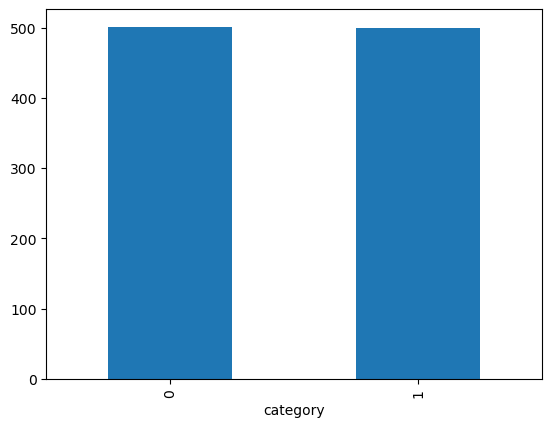

In [14]:
df['category'].value_counts().plot.bar()

In [16]:
df['category'] = df['category'].apply(str)

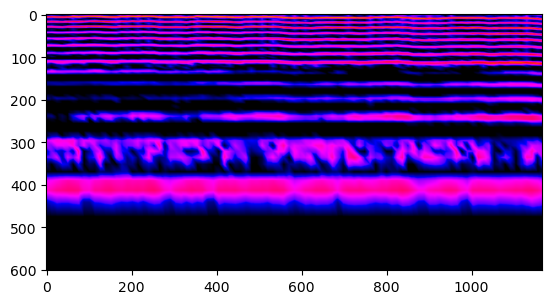

In [18]:
sample = random.choice(filenames)
image = load_img("Drives/"+sample)
plt.imshow(image)

In [20]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

#validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
#train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Drives/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 899 validated image filenames belonging to 2 classes.


C:\Users\andre\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Drives/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 101 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


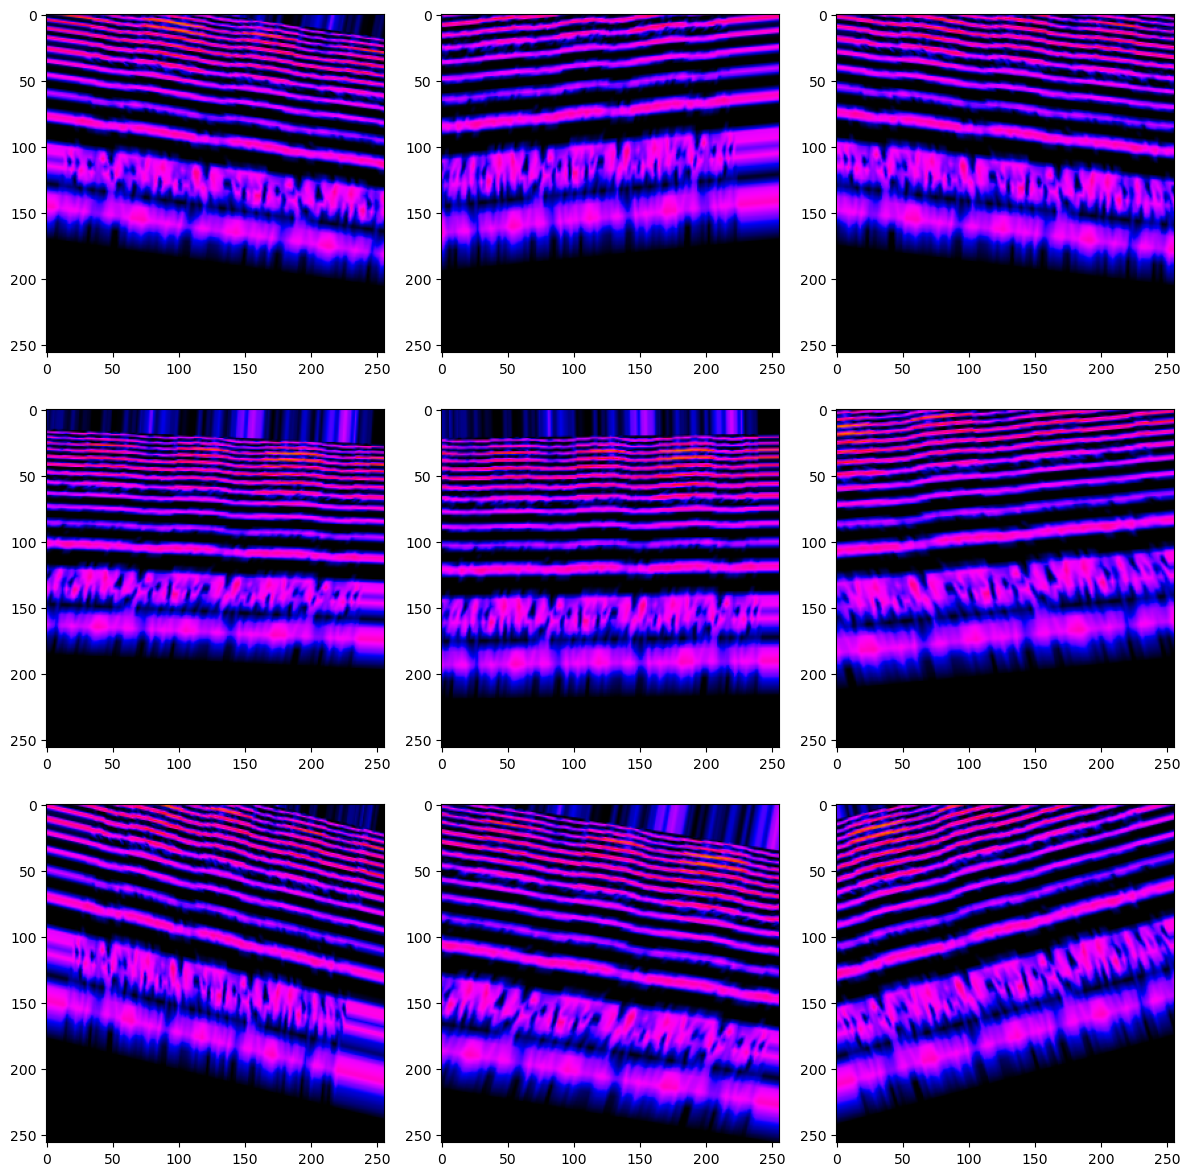

In [28]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "Drives/", 
    x_col='filename',
    y_col='category',
#    class_mode='binary'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [30]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

C:\Users\andre\AppData\Local\Temp\ipykernel_24924\42373465.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
56/56 [==============================] - 58s 1s/step - loss: 0.7456 - accuracy: 0.4926 - val_loss: 0.6934 - val_accuracy: 0.4792
Epoch 2/5
56/56 [==============================] - 60s 1s/step - loss: 0.6936 - accuracy: 0.4858 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
56/56 [==============================] - 61s 1s/step - loss: 0.6958 - accuracy: 0.4745 - val_loss: 0.6935 - val_accuracy: 0.4792
Epoch 4/5
56/56 [==============================] - 61s 1s/step - loss: 0.6940 - accuracy: 0.4824 - val_loss: 0.6936 - val_accuracy: 0.4896
Epoch 5/5
56/56 [==============================] - 61s 1s/step - loss: 0.6944 - accuracy: 0.4745 - val_loss: 0.6932 - val_accuracy: 0.5000


In [32]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

C:\Users\andre\AppData\Local\Temp\ipykernel_24924\2489114373.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.520833  ;  loss = 0.692973 


TypeError: 0.5 must be a sequence

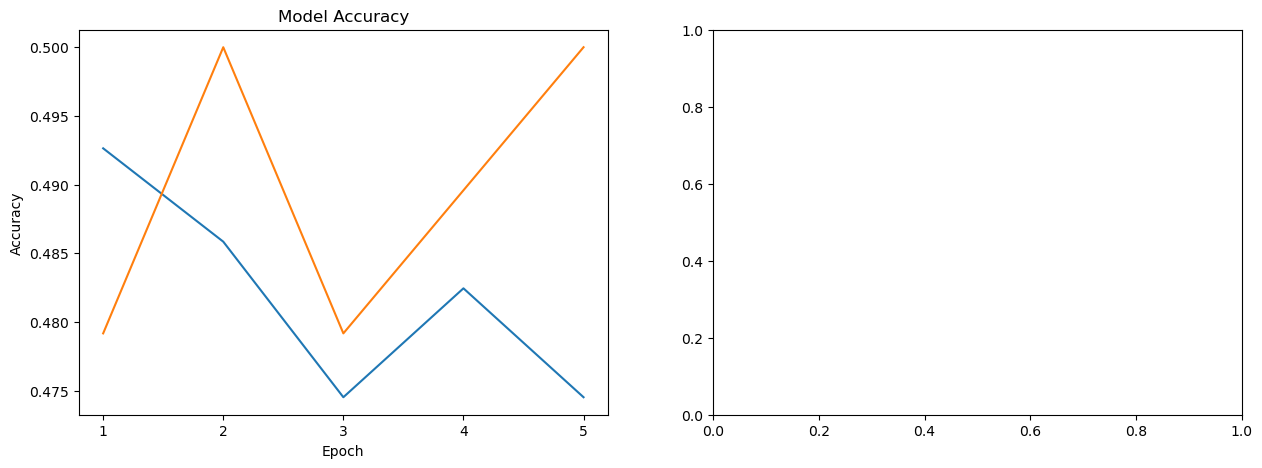

In [34]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [36]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

C:\Users\andre\AppData\Local\Temp\ipykernel_24924\3041536869.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred =  model.predict_generator(validation_generator)


In [38]:
Y_val

0      0
1      0
2      1
3      1
4      0
      ..
96     0
97     1
98     0
99     1
100    0
Name: category, Length: 101, dtype: object

In [40]:
Data_Y_val = pd.DataFrame(Y_val)

In [42]:
Data_Y_val['category'] = Data_Y_val['category'].astype(str)

In [44]:
Data_Y_val.dtypes

category    object
dtype: object

In [46]:
Data_Y_val.to_numpy()

array([['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['1'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
       ['1'],
       ['1'],
       ['0'],
       ['0'],
       ['0'],
      

In [48]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [50]:
y_final.size

101

In [52]:
data_y_final = pd.DataFrame(y_final)

In [54]:
data_y_final.columns = ['category']

In [56]:
data_y_final['category'] = data_y_final['category'].astype(str)

In [58]:
data_y_final.dtypes

category    object
dtype: object

In [60]:
data_y_final.to_numpy()

array([['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
       ['1'],
      

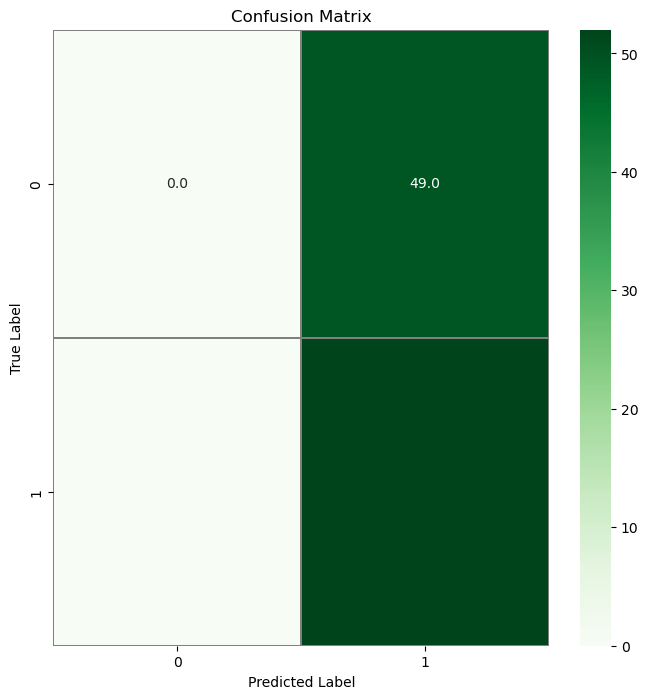

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Data_Y_val, data_y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [64]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Data_Y_val, data_y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.51      1.00      0.68        52

    accuracy                           0.51       101
   macro avg       0.26      0.50      0.34       101
weighted avg       0.27      0.51      0.35       101



C:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
test_filenames = os.listdir("Drives")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [100]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Drives_Test2", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 1001 validated image filenames.


C:\Users\andre\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [74]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

C:\Users\andre\AppData\Local\Temp\ipykernel_24924\10802553.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


ValueError: Length of values (1001) does not match length of index (1002)

In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Drives"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()